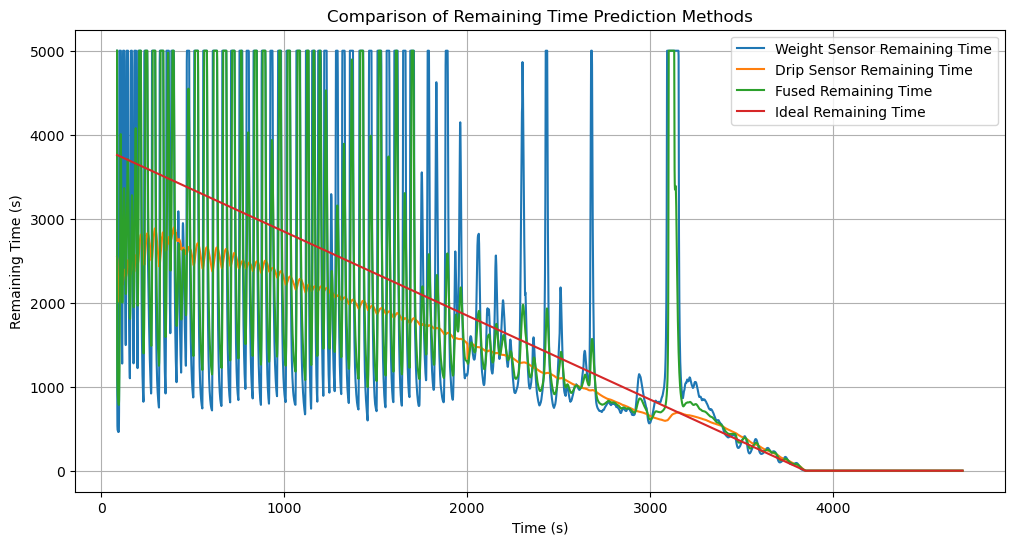

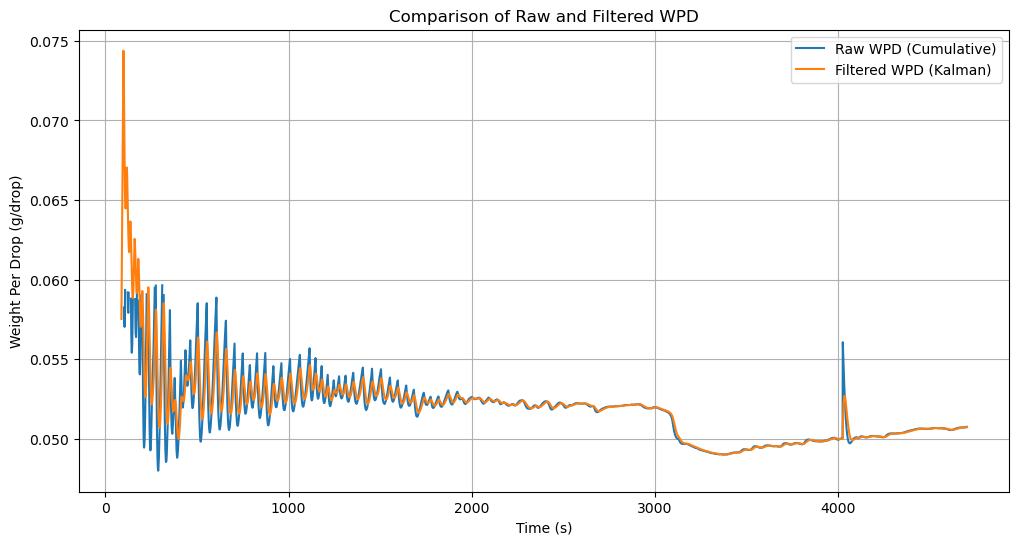

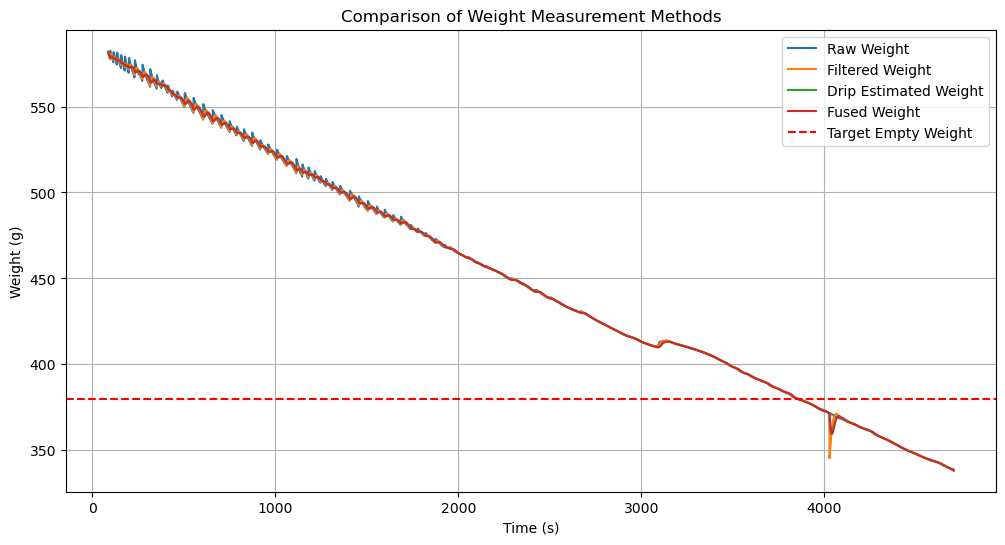

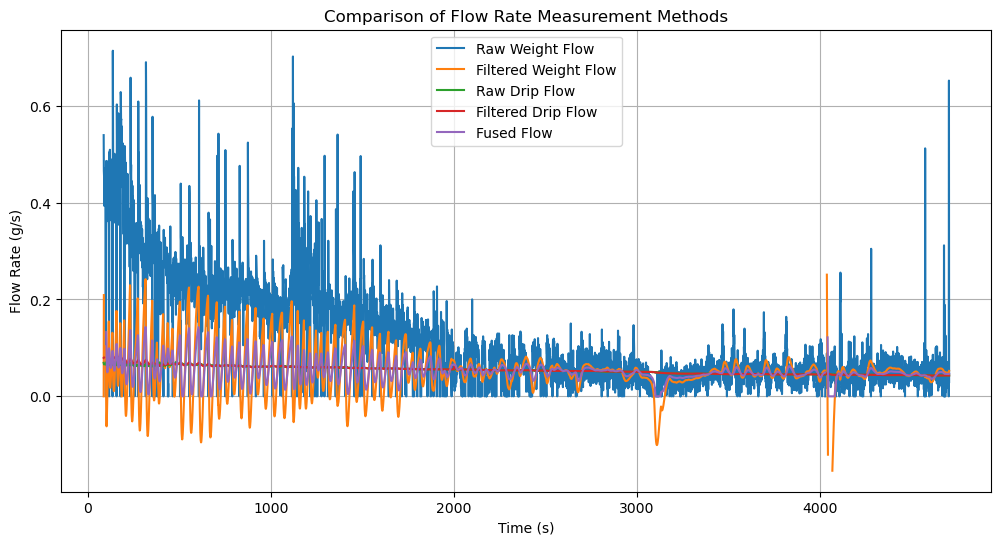

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========== 1. 读取数据 ==========
df = pd.read_csv('/Users/owen/Documents/PlatformIO/Projects/Smart_infusion_PIO/data/collected_infusion_data/infusion_data_session_20250510_161347.csv')

timestamp = df['timestamp_ms'].values / 1000.0
# 从CSV文件中提取原始数据
raw_weight = df['raw_w_g'].values            # 原始重量数据 (g)
raw_drip_rate = df['raw_dps'].values         # 原始滴速数据 (drops/second)
raw_flow_weight_gps = df['raw_flow_w_gps'].values  # 基于重量传感器计算的原始流速 (g/s)
raw_flow_drip_gps = df['raw_flow_d_gps'].values    # 基于滴速传感器计算的原始流速 (g/s)
rem_weight_drip = df['rem_weight_drip_g'].values   # 基于滴速计算的剩余重量估计 (g)

# 新增字段
if 'drip_total_drops' in df.columns:
    drip_total_drops = df['drip_total_drops'].values
else:
    drip_total_drops = df['total_drops_for_volume_calc'].values
if 'drip_initial_weight' in df.columns:
    drip_initial_weight = df['drip_initial_weight'].values
else:
    drip_initial_weight = df['known_initial_total_weight_g'].values

dt = np.diff(timestamp, prepend=timestamp[0])

# ========== 2. 固定参数 ==========
# 卡尔曼滤波器参数
WPD_INIT = 0.05  # 初始每滴重量(Weight Per Drop)，单位：g/滴
# 重量卡尔曼滤波器参数
weight_sigma_a = 0.01  # 重量过程噪声标准差，表示重量变化的不确定性
weight_R = 2.0         # 重量测量噪声方差，表示重量传感器的噪声水平

# 滴速卡尔曼滤波器参数
drip_sigma_a = 0.01    # 滴速过程噪声标准差，表示滴速变化的不确定性
drip_R = 0.5           # 滴速测量噪声方差，表示滴速传感器的噪声水平

# 流速融合卡尔曼滤波器参数
q_flow = 0.0001        # 流速过程噪声方差，表示流速变化的不确定性
r_weight_flow = 0.0025 # 基于重量计算的流速测量噪声方差
r_drip_flow = 0.0025   # 基于滴速计算的流速测量噪声方差

# 剩余重量融合卡尔曼滤波器参数
q_weight = 0.01        # 剩余重量过程噪声方差，表示重量变化的不确定性
r_weight_weight = 2.0  # 直接测量的重量噪声方差
r_drip_weight = 1.0    # 基于滴速计算的重量噪声方差

target_empty_weight = 380.0  # 输液结束重量阈值，单位：g

# ========== 3. WeightKalmanFilter ==========
def run_weight_kf(raw_weight, dt, sigma_a, R):
    x = np.zeros((2, len(raw_weight)))
    P = np.zeros((2, 2, len(raw_weight)))
    x[:, 0] = [raw_weight[0], 0]
    P[:, :, 0] = np.eye(2) * 10
    for k in range(1, len(raw_weight)):
        F = np.array([[1, dt[k]], [0, 1]])
        Q = sigma_a**2 * np.array([[dt[k]**4/4, dt[k]**3/2], [dt[k]**3/2, dt[k]**2]])
        x_pred = F @ x[:, k-1]
        P_pred = F @ P[:, :, k-1] @ F.T + Q
        H = np.array([[1, 0]])
        z = np.array([raw_weight[k]])
        y = z - H @ x_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T / S
        x[:, k] = x_pred + (K.flatten() * y)
        P[:, :, k] = (np.eye(2) - K @ H) @ P_pred
    return x[0], x[1]  # 重量, 速度

# ========== 4. DripKalmanFilter ==========
def run_drip_kf(raw_drip_rate, dt, sigma_a, R):
    x = np.zeros((2, len(raw_drip_rate)))
    P = np.zeros((2, 2, len(raw_drip_rate)))
    x[:, 0] = [raw_drip_rate[0], 0]
    P[:, :, 0] = np.eye(2) * 1
    for k in range(1, len(raw_drip_rate)):
        F = np.array([[1, dt[k]], [0, 1]])
        Q = sigma_a**2 * np.array([[dt[k]**4/4, dt[k]**3/2], [dt[k]**3/2, dt[k]**2]])
        x_pred = F @ x[:, k-1]
        P_pred = F @ P[:, :, k-1] @ F.T + Q
        H = np.array([[1, 0]])
        z = np.array([raw_drip_rate[k]])
        y = z - H @ x_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T / S
        x[:, k] = x_pred + (K.flatten() * y)
        P[:, :, k] = (np.eye(2) - K @ H) @ P_pred
    return x[0], x[1]  # 滴速, 滴速变化率

def kalman_1d(measurements, Q=1e-6, R=1e-4, x0=0.05):
    x = np.zeros_like(measurements)
    P = 1.0
    for k in range(len(measurements)):
        if np.isnan(measurements[k]) or measurements[k] < 0.01 or measurements[k] > 0.2:
            if k > 0:
                x[k] = x[k-1]
            else:
                x[k] = x0
            continue
        P = P + Q
        K = P / (P + R)
        if k == 0:
            x[k] = measurements[k]
        else:
            x[k] = x[k-1] + K * (measurements[k] - x[k-1])
        P = (1 - K) * P
    return x

# ========== 5. DataFusion ==========
def run_data_fusion(flow_weight, flow_drip, rem_weight_weight, rem_weight_drip, dt, 
                    q_flow, r_weight_flow, r_drip_flow, q_weight, r_weight_weight, r_drip_weight):
    n = len(flow_weight)
    fused_flow = np.zeros(n)
    fused_weight = np.zeros(n)
    P_flow = 1.0
    P_weight = 10.0
    fused_flow[0] = flow_weight[0]
    fused_weight[0] = rem_weight_weight[0]
    for k in range(1, n):
        # 预测
        P_flow += q_flow * dt[k]
        P_weight += q_weight * dt[k]
        fused_weight[k] = fused_weight[k-1] - fused_flow[k-1] * dt[k]
        if fused_weight[k] < 0: fused_weight[k] = 0
        # 流速更新
        K1 = P_flow / (P_flow + r_weight_flow)
        fused_flow[k] = fused_flow[k-1] + K1 * (flow_weight[k] - fused_flow[k-1])
        P_flow = (1 - K1) * P_flow
        K2 = P_flow / (P_flow + r_drip_flow)
        fused_flow[k] = fused_flow[k] + K2 * (flow_drip[k] - fused_flow[k])
        P_flow = (1 - K2) * P_flow
        # 剩余重量更新
        K3 = P_weight / (P_weight + r_weight_weight)
        fused_weight[k] = fused_weight[k] + K3 * (rem_weight_weight[k] - fused_weight[k])
        P_weight = (1 - K3) * P_weight
        K4 = P_weight / (P_weight + r_drip_weight)
        fused_weight[k] = fused_weight[k] + K4 * (rem_weight_drip[k] - fused_weight[k])
        P_weight = (1 - K4) * P_weight
        if fused_weight[k] < 0: fused_weight[k] = 0
    return fused_flow, fused_weight

# ========== 6. 剩余时间预测与理想线性剩余时间 ==========
def calc_remaining_time(weight, flow, target_weight):
    rem = weight - target_weight
    rem[rem < 0] = 0
    flow[flow < 1e-5] = 1e-5  # 防止除零
    remaining_time = rem / flow
    # 限制剩余时间范围在0-5000秒之间
    remaining_time[remaining_time > 5000] = 5000
    return remaining_time

def calc_ideal_remaining_time(timestamp, fused_weight, target_weight):
    end_idx = np.where(fused_weight <= target_weight + 0.1)[0]
    if len(end_idx) == 0:
        end_idx = [-1]
    end_time = timestamp[end_idx[0]]
    ideal_time = end_time - timestamp
    ideal_time[ideal_time < 0] = 0
    return ideal_time

# ========== 7. 主流程 ==========
if __name__ == '__main__':
    # 1. 重量卡尔曼滤波
    filt_weight, filt_weight_vel = run_weight_kf(raw_weight, dt, weight_sigma_a, weight_R)
    # 2. WPD累计法与卡尔曼滤波
    wpd_cumulative = np.full_like(raw_weight, np.nan)
    for k in range(len(raw_weight)):
        if drip_total_drops[k] > 0:
            wpd_cumulative[k] = (drip_initial_weight[k] - filt_weight[k]) / drip_total_drops[k]
    wpd_kf = kalman_1d(wpd_cumulative)
    # 3. 滴速卡尔曼滤波（用滤波WPD）
    filt_drip_rate, _ = run_drip_kf(raw_drip_rate, dt, drip_sigma_a, drip_R)
    filt_drip_flow_gps = filt_drip_rate * wpd_kf
    # 4. 滴数法剩余重量估算
    drip_est_weight = drip_initial_weight - drip_total_drops * wpd_kf
    # 5. 数据融合
    fused_flow, fused_weight = run_data_fusion(-filt_weight_vel, filt_drip_flow_gps, 
                                              filt_weight, drip_est_weight, dt,
                                              q_flow, r_weight_flow, r_drip_flow, 
                                              q_weight, r_weight_weight, r_drip_weight)
    
    # 6. 计算各种剩余时间
    weight_rem_time = calc_remaining_time(filt_weight, -filt_weight_vel, target_empty_weight)
    drip_rem_time = calc_remaining_time(drip_est_weight, filt_drip_flow_gps, target_empty_weight)
    fused_rem_time = calc_remaining_time(fused_weight, fused_flow, target_empty_weight)
    ideal_rem_time = calc_ideal_remaining_time(timestamp, filt_weight, target_empty_weight)
    
    # 7. 可视化（剔除异常值）
    # 定义异常值过滤函数
    def filter_outliers(data, threshold=3):
        """
        使用z-score方法剔除异常值
        threshold: z-score阈值，默认为3
        """
        if np.all(np.isnan(data)):
            return data
        
        # 创建掩码，初始所有点都是有效的
        mask = ~np.isnan(data)
        
        # 计算均值和标准差（忽略NaN值）
        mean = np.nanmean(data)
        std = np.nanstd(data)
        
        if std == 0:  # 防止除零错误
            return data
        
        # 计算z-scores
        z_scores = np.abs((data - mean) / std)
        
        # 标记异常值
        mask = mask & (z_scores < threshold)
        
        # 创建过滤后的数据副本
        filtered_data = data.copy()
        filtered_data[~mask] = np.nan
        
        return filtered_data, mask
    
    # 图1：剩余时间对比（剔除异常值）
    plt.figure(figsize=(12, 6))
    # 过滤异常值
    weight_rem_time_filtered, _ = filter_outliers(weight_rem_time)
    drip_rem_time_filtered, _ = filter_outliers(drip_rem_time)
    fused_rem_time_filtered, _ = filter_outliers(fused_rem_time)
    
    plt.plot(timestamp, weight_rem_time_filtered, label='Weight Sensor Remaining Time')
    plt.plot(timestamp, drip_rem_time_filtered, label='Drip Sensor Remaining Time')
    plt.plot(timestamp, fused_rem_time_filtered, label='Fused Remaining Time')
    plt.plot(timestamp, ideal_rem_time, label='Ideal Remaining Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Remaining Time (s)')
    plt.legend()
    plt.title('Comparison of Remaining Time Prediction Methods')
    plt.grid(True)
    plt.show()
    
    # 图2：WPD对比（剔除异常值）
    plt.figure(figsize=(12, 6))
    # 过滤异常值
    wpd_cumulative_filtered, _ = filter_outliers(wpd_cumulative)
    
    plt.plot(timestamp, wpd_cumulative_filtered, label='Raw WPD (Cumulative)')
    plt.plot(timestamp, wpd_kf, label='Filtered WPD (Kalman)')
    plt.xlabel('Time (s)')
    plt.ylabel('Weight Per Drop (g/drop)')
    plt.legend()
    plt.title('Comparison of Raw and Filtered WPD')
    plt.grid(True)
    plt.show()
    
    # 图3：重量对比
    plt.figure(figsize=(12, 6))
    # 过滤异常值
    raw_weight_filtered, _ = filter_outliers(raw_weight)
    
    plt.plot(timestamp, raw_weight_filtered, label='Raw Weight')
    plt.plot(timestamp, filt_weight, label='Filtered Weight')
    plt.plot(timestamp, drip_est_weight, label='Drip Estimated Weight')
    plt.plot(timestamp, fused_weight, label='Fused Weight')
    plt.axhline(target_empty_weight, color='r', linestyle='--', label='Target Empty Weight')
    plt.xlabel('Time (s)')
    plt.ylabel('Weight (g)')
    plt.legend()
    plt.title('Comparison of Weight Measurement Methods')
    plt.grid(True)
    plt.show()
    
    # 图4：流速对比（剔除异常值）
    plt.figure(figsize=(12, 6))
    # 过滤异常值
    raw_flow_weight_gps_filtered, _ = filter_outliers(raw_flow_weight_gps)
    filt_weight_vel_filtered, _ = filter_outliers(-filt_weight_vel)
    raw_flow_drip_gps_filtered, _ = filter_outliers(raw_flow_drip_gps)
    filt_drip_flow_gps_filtered, _ = filter_outliers(filt_drip_flow_gps)
    fused_flow_filtered, _ = filter_outliers(fused_flow)
    
    plt.plot(timestamp, raw_flow_weight_gps_filtered, label='Raw Weight Flow')
    plt.plot(timestamp, filt_weight_vel_filtered, label='Filtered Weight Flow')
    plt.plot(timestamp, raw_flow_drip_gps_filtered, label='Raw Drip Flow')
    plt.plot(timestamp, filt_drip_flow_gps_filtered, label='Filtered Drip Flow')
    plt.plot(timestamp, fused_flow_filtered, label='Fused Flow')
    plt.xlabel('Time (s)')
    plt.ylabel('Flow Rate (g/s)')
    plt.legend()
    plt.title('Comparison of Flow Rate Measurement Methods')
    plt.grid(True)
    plt.show()


In [18]:
import numpy as np
from scipy.optimize import minimize

# 假设你已经有如下函数和数据：
# run_weight_kf, run_drip_kf, kalman_1d, run_data_fusion, calc_remaining_time, calc_ideal_remaining_time
# 以及 timestamp, raw_weight, raw_drip_rate, raw_flow_weight_gps, drip_total_drops, drip_initial_weight, dt, target_empty_weight

def objective(params):
    # 参数解包
    weight_sigma_a, weight_R, drip_sigma_a, drip_R, q_flow, r_weight_flow, r_drip_flow, q_weight, r_weight_weight, r_drip_weight = params

    # 1. 重量卡尔曼滤波
    filt_weight, filt_weight_vel = run_weight_kf(raw_weight, dt, weight_sigma_a, weight_R)
    # 2. WPD累计法与卡尔曼滤波
    wpd_cumulative = np.full_like(raw_weight, np.nan)
    for k in range(len(raw_weight)):
        if drip_total_drops[k] > 0:
            wpd_cumulative[k] = (drip_initial_weight[k] - filt_weight[k]) / drip_total_drops[k]
    wpd_kf = kalman_1d(wpd_cumulative)
    # 3. 滴速卡尔曼滤波
    filt_drip_rate, _ = run_drip_kf(raw_drip_rate, dt, drip_sigma_a, drip_R)
    filt_drip_flow_gps = filt_drip_rate * wpd_kf
    # 4. 滴数法剩余重量估算
    drip_est_weight = drip_initial_weight - drip_total_drops * wpd_kf
    # 5. 剩余时间
    fused_rem_time = calc_remaining_time(drip_est_weight, filt_drip_flow_gps, target_empty_weight)
    ideal_rem_time = calc_ideal_remaining_time(timestamp, drip_est_weight, target_empty_weight)
    mask = (drip_est_weight > target_empty_weight)
    mse = np.mean((fused_rem_time[mask] - ideal_rem_time[mask])**2)
    return mse

# 参数初值和边界（可根据实际情况调整）
x0 = [0.01, 2.0, 0.01, 0.5, 0.0001, 0.0025, 0.0025, 0.01, 1.0, 2.0]
bounds = [
    (0.001, 0.1),   # weight_sigma_a
    (30, 80.0),    # weight_R
    (0.001, 0.1),   # drip_sigma_a
    (0.01, 5.0),    # drip_R
    (1e-6, 1e-2),   # q_flow
    (1e-6, 1e-1),   # r_weight_flow
    (1e-6, 1e-1),   # r_drip_flow
    (1e-4, 0.1),    # q_weight
    (0.1, 10.0),    # r_weight_weight
    (0.1, 10.0),    # r_drip_weight
]

# 优化
result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')
print("最优参数：", result.x)
print("最小MSE：", result.fun)

最优参数： [7.003167e-02 3.000000e+01 1.000000e-03 5.000000e+00 1.000000e-04
 2.500000e-03 2.500000e-03 1.000000e-02 1.000000e+00 2.000000e+00]
最小MSE： 227070.0168876392


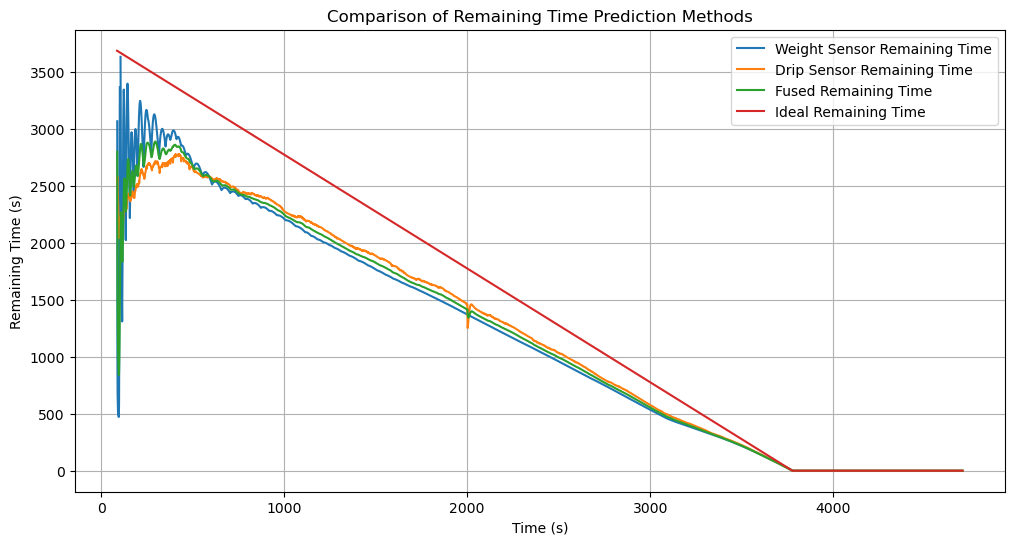

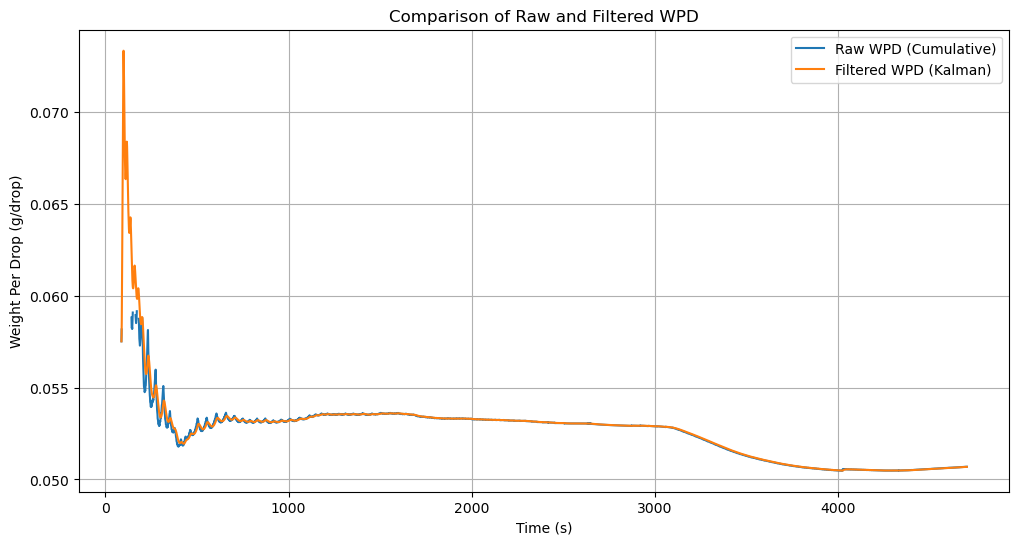

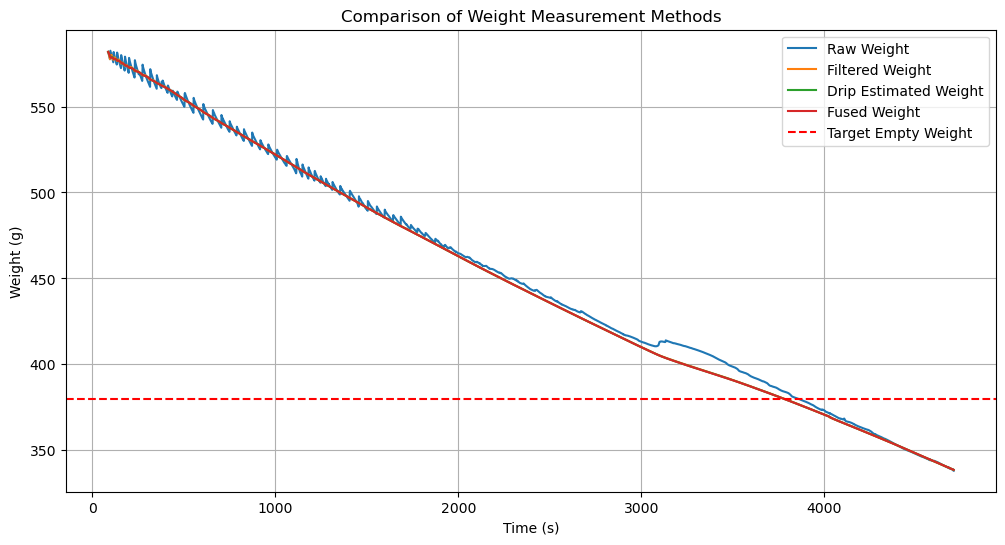

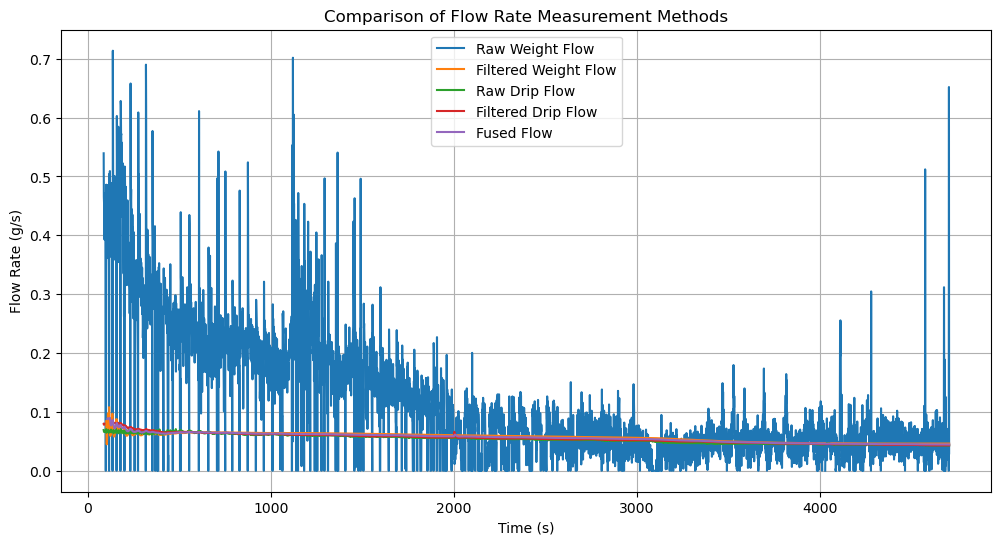

In [17]:
# 使用最优参数
weight_sigma_a = 0.00001
weight_R = 50
drip_sigma_a = 2.59597933e-02
drip_R = 1.34585525e+00
q_flow = 1.00000000e-04
r_weight_flow = 2.50000000e-03
r_drip_flow = 2.50000000e-03
q_weight = 1.00000000e-02
r_weight_weight = 1.00000000e+00
r_drip_weight = 2.00000000e+00

# 1. 重量卡尔曼滤波
filt_weight, filt_weight_vel = run_weight_kf(raw_weight, dt, weight_sigma_a, weight_R)
# 2. WPD累计法与卡尔曼滤波
wpd_cumulative = np.full_like(raw_weight, np.nan)
for k in range(len(raw_weight)):
    if drip_total_drops[k] > 0:
        wpd_cumulative[k] = (drip_initial_weight[k] - filt_weight[k]) / drip_total_drops[k]
wpd_kf = kalman_1d(wpd_cumulative)
# 3. 滴速卡尔曼滤波（用滤波WPD）
filt_drip_rate, _ = run_drip_kf(raw_drip_rate, dt, drip_sigma_a, drip_R)
filt_drip_flow_gps = filt_drip_rate * wpd_kf
# 4. 滴数法剩余重量估算
drip_est_weight = drip_initial_weight - drip_total_drops * wpd_kf
# 5. 数据融合
fused_flow, fused_weight = run_data_fusion(-filt_weight_vel, filt_drip_flow_gps, 
                                            filt_weight, drip_est_weight, dt,
                                            q_flow, r_weight_flow, r_drip_flow, 
                                            q_weight, r_weight_weight, r_drip_weight)

# 6. 计算各种剩余时间
weight_rem_time = calc_remaining_time(filt_weight, -filt_weight_vel, target_empty_weight)
drip_rem_time = calc_remaining_time(drip_est_weight, filt_drip_flow_gps, target_empty_weight)
fused_rem_time = calc_remaining_time(fused_weight, fused_flow, target_empty_weight)
ideal_rem_time = calc_ideal_remaining_time(timestamp, filt_weight, target_empty_weight)

# 7. 可视化（剔除异常值）
# 定义异常值过滤函数
def filter_outliers(data, threshold=3):
    """
    使用z-score方法剔除异常值
    threshold: z-score阈值，默认为3
    """
    if np.all(np.isnan(data)):
        return data
    
    # 创建掩码，初始所有点都是有效的
    mask = ~np.isnan(data)
    
    # 计算均值和标准差（忽略NaN值）
    mean = np.nanmean(data)
    std = np.nanstd(data)
    
    if std == 0:  # 防止除零错误
        return data
    
    # 计算z-scores
    z_scores = np.abs((data - mean) / std)
    
    # 标记异常值
    mask = mask & (z_scores < threshold)
    
    # 创建过滤后的数据副本
    filtered_data = data.copy()
    filtered_data[~mask] = np.nan
    
    return filtered_data, mask

# 图1：剩余时间对比（剔除异常值）
plt.figure(figsize=(12, 6))
# 过滤异常值
weight_rem_time_filtered, _ = filter_outliers(weight_rem_time)
drip_rem_time_filtered, _ = filter_outliers(drip_rem_time)
fused_rem_time_filtered, _ = filter_outliers(fused_rem_time)

plt.plot(timestamp, weight_rem_time_filtered, label='Weight Sensor Remaining Time')
plt.plot(timestamp, drip_rem_time_filtered, label='Drip Sensor Remaining Time')
plt.plot(timestamp, fused_rem_time_filtered, label='Fused Remaining Time')
plt.plot(timestamp, ideal_rem_time, label='Ideal Remaining Time')
plt.xlabel('Time (s)')
plt.ylabel('Remaining Time (s)')
plt.legend()
plt.title('Comparison of Remaining Time Prediction Methods')
plt.grid(True)
plt.show()

# 图2：WPD对比（剔除异常值）
plt.figure(figsize=(12, 6))
# 过滤异常值
wpd_cumulative_filtered, _ = filter_outliers(wpd_cumulative)

plt.plot(timestamp, wpd_cumulative_filtered, label='Raw WPD (Cumulative)')
plt.plot(timestamp, wpd_kf, label='Filtered WPD (Kalman)')
plt.xlabel('Time (s)')
plt.ylabel('Weight Per Drop (g/drop)')
plt.legend()
plt.title('Comparison of Raw and Filtered WPD')
plt.grid(True)
plt.show()

# 图3：重量对比
plt.figure(figsize=(12, 6))
# 过滤异常值
raw_weight_filtered, _ = filter_outliers(raw_weight)

plt.plot(timestamp, raw_weight_filtered, label='Raw Weight')
plt.plot(timestamp, filt_weight, label='Filtered Weight')
plt.plot(timestamp, drip_est_weight, label='Drip Estimated Weight')
plt.plot(timestamp, fused_weight, label='Fused Weight')
plt.axhline(target_empty_weight, color='r', linestyle='--', label='Target Empty Weight')
plt.xlabel('Time (s)')
plt.ylabel('Weight (g)')
plt.legend()
plt.title('Comparison of Weight Measurement Methods')
plt.grid(True)
plt.show()

# 图4：流速对比（剔除异常值）
plt.figure(figsize=(12, 6))
# 过滤异常值
raw_flow_weight_gps_filtered, _ = filter_outliers(raw_flow_weight_gps)
filt_weight_vel_filtered, _ = filter_outliers(-filt_weight_vel)
raw_flow_drip_gps_filtered, _ = filter_outliers(raw_flow_drip_gps)
filt_drip_flow_gps_filtered, _ = filter_outliers(filt_drip_flow_gps)
fused_flow_filtered, _ = filter_outliers(fused_flow)

plt.plot(timestamp, raw_flow_weight_gps_filtered, label='Raw Weight Flow')
plt.plot(timestamp, filt_weight_vel_filtered, label='Filtered Weight Flow')
plt.plot(timestamp, raw_flow_drip_gps_filtered, label='Raw Drip Flow')
plt.plot(timestamp, filt_drip_flow_gps_filtered, label='Filtered Drip Flow')
plt.plot(timestamp, fused_flow_filtered, label='Fused Flow')
plt.xlabel('Time (s)')
plt.ylabel('Flow Rate (g/s)')
plt.legend()
plt.title('Comparison of Flow Rate Measurement Methods')
plt.grid(True)
plt.show()

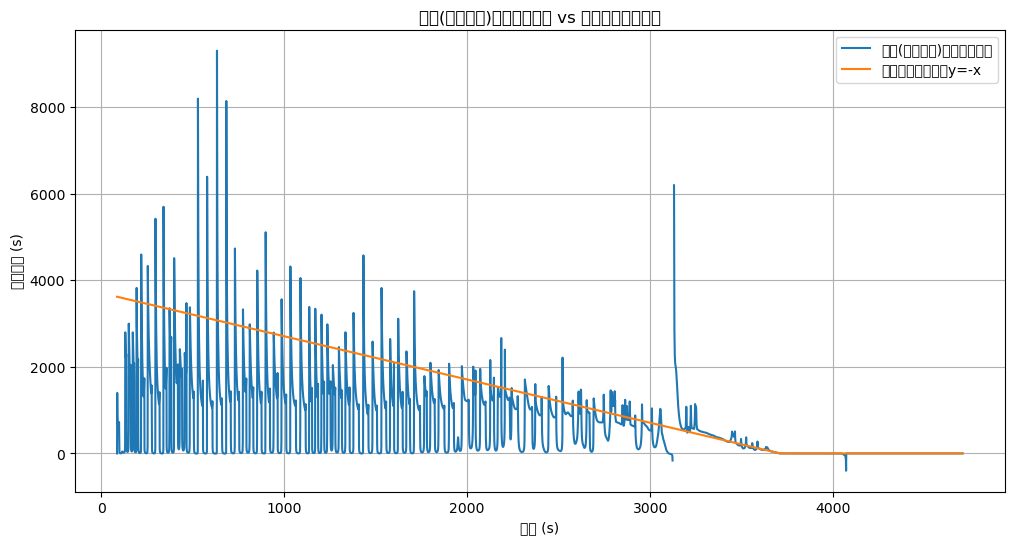

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ========== 1. 预处理与滤波 ==========
# 假设你已定义 run_weight_kf, run_drip_kf, kalman_1d，并有原始数据变量
# 这里参数可根据你实际情况调整
filt_weight, filt_weight_vel = run_weight_kf(raw_weight, dt, 0.01, 2.0)
wpd_cumulative = np.full_like(raw_weight, np.nan)
for k in range(len(raw_weight)):
    if drip_total_drops[k] > 0:
        wpd_cumulative[k] = (drip_initial_weight[k] - filt_weight[k]) / drip_total_drops[k]
wpd_kf = kalman_1d(wpd_cumulative)
filt_drip_rate, filt_drip_acc = run_drip_kf(raw_drip_rate, dt, 0.01, 0.5)
filt_drip_flow_gps = filt_drip_rate * wpd_kf
filt_drip_flow_gps_acc = filt_drip_acc * wpd_kf
drip_est_weight = drip_initial_weight - drip_total_drops * wpd_kf

# ========== 2. 数据融合（流速+加速度） ==========
def run_data_fusion_with_acc(flow_weight, flow_drip, rem_weight_weight, rem_weight_drip, dt,
                            q_v=1e-5, q_a=1e-7, r_weight_v=1e-3, r_drip_v=1e-3, r_weight_a=1e-4, r_drip_a=1e-4):
    n = len(flow_weight)
    fused_v = np.zeros(n)
    fused_a = np.zeros(n)
    fused_weight = np.zeros(n)
    P = np.eye(2) * 1.0  # 状态协方差
    Q = np.array([[q_v, 0], [0, q_a]])
    fused_v[0] = flow_weight[0]
    fused_a[0] = 0
    fused_weight[0] = rem_weight_weight[0]
    for k in range(1, n):
        # 状态预测
        F = np.array([[1, dt[k]], [0, 1]])
        x_pred = np.array([fused_v[k-1], fused_a[k-1]])
        x_pred = F @ x_pred
        P = F @ P @ F.T + Q
        # 观测
        z_v = np.array([flow_weight[k], flow_drip[k]])
        z_a = np.array([
            (flow_weight[k] - flow_weight[k-1]) / dt[k],
            (flow_drip[k] - flow_drip[k-1]) / dt[k]
        ])
        # 融合流速观测
        H_v = np.array([[1, 0], [1, 0]])
        R_v = np.diag([r_weight_v, r_drip_v])
        y_v = z_v - H_v @ x_pred
        S_v = H_v @ P @ H_v.T + R_v
        K_v = P @ H_v.T @ np.linalg.inv(S_v)
        x_upd = x_pred + K_v @ y_v
        P = (np.eye(2) - K_v @ H_v) @ P
        # 融合加速度观测
        H_a = np.array([[0, 1], [0, 1]])
        R_a = np.diag([r_weight_a, r_drip_a])
        y_a = z_a - H_a @ x_upd
        S_a = H_a @ P @ H_a.T + R_a
        K_a = P @ H_a.T @ np.linalg.inv(S_a)
        x_upd = x_upd + K_a @ y_a
        P = (np.eye(2) - K_a @ H_a) @ P
        # 保存
        fused_v[k], fused_a[k] = x_upd
        fused_weight[k] = fused_weight[k-1] - fused_v[k] * dt[k]
        if fused_weight[k] < 0: fused_weight[k] = 0
    return fused_v, fused_a, fused_weight

# ========== 3. 融合 ==========
fused_v, fused_a, fused_weight = run_data_fusion_with_acc(
    flow_weight=-filt_weight_vel,
    flow_drip=filt_drip_flow_gps,
    rem_weight_weight=filt_weight,
    rem_weight_drip=drip_est_weight,
    dt=dt
)

# ========== 4. 剩余时间预测（考虑加速度） ==========
def predict_time_linear_decay(rem_weight, v0, a):
    a = np.where(np.abs(a) < 1e-8, -1e-8, a)
    delta = v0**2 + 2*a*rem_weight
    delta = np.where(delta < 0, 0, delta)
    T = (-v0 + np.sqrt(delta)) / a
    T = np.where(a < 0, T, rem_weight / np.maximum(v0, 1e-6))
    return T

rem_weight = fused_weight - target_empty_weight
rem_weight[rem_weight < 0] = 0
fused_rem_time_acc = predict_time_linear_decay(rem_weight, fused_v, fused_a)

# 理想线性剩余时间
def calc_ideal_remaining_time(timestamp, fused_weight, target_weight):
    end_idx = np.where(fused_weight <= target_weight + 0.1)[0]
    if len(end_idx) == 0:
        end_idx = [-1]
    end_time = timestamp[end_idx[0]]
    ideal_time = end_time - timestamp
    ideal_time[ideal_time < 0] = 0
    return ideal_time

ideal_rem_time = calc_ideal_remaining_time(timestamp, fused_weight, target_empty_weight)

# ========== 5. 可视化 ==========
plt.figure(figsize=(12,6))
# 剔除异常值
max_time_threshold = 10000  # 设置一个合理的最大剩余时间阈值
filtered_fused_time = np.copy(fused_rem_time_acc)
filtered_fused_time[filtered_fused_time > max_time_threshold] = np.nan  # 将异常值替换为NaN

plt.plot(timestamp, filtered_fused_time, label='融合(含加速度)预测剩余时间')
plt.plot(timestamp, ideal_rem_time, label='理想线性剩余时间y=-x')
plt.xlabel('时间 (s)')
plt.ylabel('剩余时间 (s)')
plt.legend()
plt.title('融合(含加速度)预测剩余时间 vs 理想线性剩余时间')
plt.grid(True)
plt.show()